In [1]:
%matplotlib inline
import numpy as np
import sklearn.cluster
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# Generate a random data matrix. n = number of data points; m = length of each data point; num_types = number of types
def gen_data(n, m, num_types):
    # type for each data point (each from 0 to n-1)
    types = np.trunc(np.random.random_sample(n)*num_types)
    # list of random vectors of m integers between 2 and 20, to serve as the mean for each type
    means = [np.random.randint(2,20,m) for t in range(num_types)]
    # list of vectors of standard deviations for each type
    stddevs = 0.5 * np.ones([num_types,m])
    # generate a data matrix and round to the nearest thousandth
    return np.round(map(lambda t : list(np.random.randn(len(means[t])) * stddevs[t] + means[t]), map(int, types)),3)

In [3]:
# run k-means clustering on M, for each k values in k_vals
def k_mean_test(M, k_vals):
    results = []
    for k in k_vals:
        fit = sklearn.cluster.KMeans(n_clusters=k).fit(M)
        var = sum(np.var(M,0))*len(M)
        within_var = sum(map(lambda r : min(r)**2, fit.transform(M)))
        results.append((k,within_var/var))
    return results

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.99999999999999978, 0.43190766386883744, 0.13196192490131656, 0.015029908628719635, 0.014037404381593488, 0.013108653194736211, 0.01215251257325472, 0.011351504258025988, 0.010763188790488789, 0.01031056870300639]]


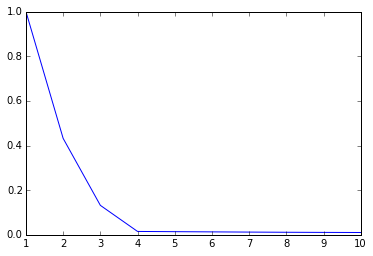

In [4]:
# generate 200 data points in R^4, with 4 topics
M = gen_data(200, 4, 4)
# plot results for k=1 to 10
plot_results = map(list, zip(*k_mean_test(M, range(1,11))))
print plot_results
plt.plot(plot_results[0], plot_results[1], 'b-')